# Analysis of spectral content before / after blurring

## Version 2

A bunch of this code is adapted from the [Gestalt revision](http://nbviewer.ipython.org/github/gestaltrevision/python_for_visres/blob/master/Part7/Part7_Image_Statistics.ipynb) notebook on image processing. Thanks to those guys for making this available!

In [1]:
# Import all the necessary packages
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import seaborn as sns
import data_helpers as helpers
from skimage import color, io, img_as_float
import pickle
import pandas as pd
from scipy.optimize import minimize_scalar
import psyutils as pu
from psyutils.image import show_im
from scipy.ndimage import gaussian_filter
from numpy.testing import assert_allclose

%matplotlib inline

# set some styles we like:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("paper")
sns.set_palette("colorblind")


In [2]:
top_dir = helpers.project_directory()
fig_dir = os.path.join(top_dir, 'figures')
im_dir = os.path.join(top_dir, 'stimuli', 'experiment-13', 'final_ims')
original_ims = '/Users/tomwallis/Dropbox/Image_Databases/mit_1003/ALLSTIMULI'

In [3]:
# blur_dat = pd.read_csv(os.path.join(top_dir, 'results', 'experiment-13', 'all_data.csv'), index_col=False)
# blur_dat = helpers.experiment_13_data_ready_for_analysis(blur_dat)

In [4]:
# load data from blur model fit:
with open (os.path.join(top_dir, 'results', 'experiment-13', 'expt_13_tanh3_full_model_fit.pkl'),
           'rb') as f:
    stan_model, fit, plot_df, param_df, pop_param_df = pickle.load(f)

In [5]:
def do_fourier_transform(img):
        
    # Do the fft
    F = np.fft.fft2(img)
    
    # Center the spectrum on the lowest frequency
    F_centered = np.fft.fftshift(F)
    
    # Extract amplitude and phase
    A = np.abs(F_centered).real
    P = np.angle(F_centered).real
    
    # Return amplitude, phase, and the full spectrum
    return A, P, F


def get_band_mask(spectrum, band, n_bands):
    """Select a circular frequency band from the spectrum"""
    # Get image coordinates, and center on 0
    x,y = np.meshgrid(range(spectrum.shape[1]),range(spectrum.shape[0]))
    x = x - np.max(x)/2
    y = y - np.max(y)/2
    
    # Compute distances from center
    radius = np.hypot(x,y)
    
    # Compute the min and max frequencies of this band
    bw = np.amin(spectrum.shape)/(n_bands*2)
    freqs = [0+bw*band,bw+bw*band]
    centre_freq = np.mean(freqs)  # centre frequeny of the band
    
    # Create the corresponding mask
    msk = np.zeros(spectrum.shape, dtype=bool)
    msk[(radius<freqs[1])*(radius>freqs[0])]=True
    
    # Do not include the zero-th frequency (overall luminance)
    msk[x.shape[0]/2,y.shape[0]/2] = False
    return msk, centre_freq


def get_circ_band(spectrum, freq_range):
    """Select a circular frequency band whose frequencies are 
    given by the tuple freq_range(f_low, f_high) in pixels. 
    
    """
    # Get image coordinates, and center on 0
    x,y = np.meshgrid(range(spectrum.shape[1]),range(spectrum.shape[0]))
    x = x - np.max(x)/2
    y = y - np.max(y)/2
    
    # Compute distances from center
    radius = np.hypot(x,y)
    
    centre_freq = np.mean(freq_range)  # centre frequeny of the band
    
    # Create the corresponding mask
    msk = np.zeros(spectrum.shape, dtype=bool)
    msk[(radius<freq_range[1])*(radius>freq_range[0])]=True
    
    # Do not include the zero-th frequency (overall luminance)
    msk[x.shape[0]/2,y.shape[0]/2] = False
    return msk, centre_freq


def get_rotational_average(A, n_bands):
    """Average over the contents of n frequency bands"""
    res = []
    freq = []
    for band in np.arange(n_bands):
        msk, centre = get_band_mask(A, band, n_bands)
        res.append(np.mean(A[msk].flatten())/A.size)
        freq.append(centre)
    return (np.array(freq, dtype=float),
            np.array(res, dtype=float))

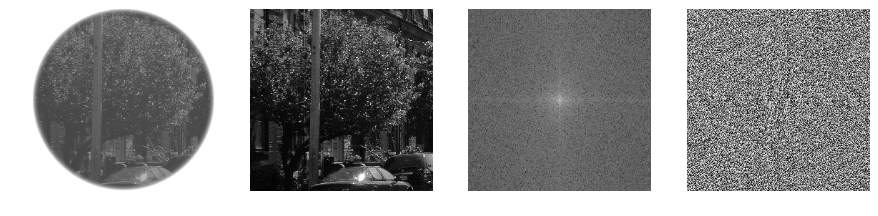

In [6]:
plt.figure(figsize=(15,5))
img = plt.imread(os.path.join(top_dir, 'stimuli', 'experiment-13', 'final_ims',
                              'i05june05_static_street_boston_p1010764_inner_nat.png'))
plt.subplot(1,4,1), plt.imshow(img), plt.axis('off')
img = color.rgb2gray(img)
plt.subplot(1,4,2), plt.imshow(img, cmap='gray'), plt.axis('off')

A, P, F = do_fourier_transform(img)

plt.subplot(1,4,3), plt.imshow(np.log(A), cmap='gray'), plt.axis('off')
plt.subplot(1,4,4), plt.imshow(P, cmap='gray'), plt.axis('off')

plt.show()

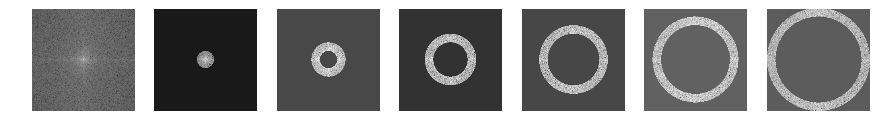

In [7]:
# illustrate band filters
n_bands = 6

plt.figure(figsize=(15,5))
plt.subplot(1, n_bands+1, 1)
plt.imshow(np.log(A),cmap='gray')
plt.axis('off')

for band in np.arange(n_bands):
    msk, freq = get_band_mask(A, band, n_bands)
    plt.subplot(1,n_bands+1,band+2)
    plt.imshow(msk*np.log(A),cmap='gray')
    plt.axis('off')

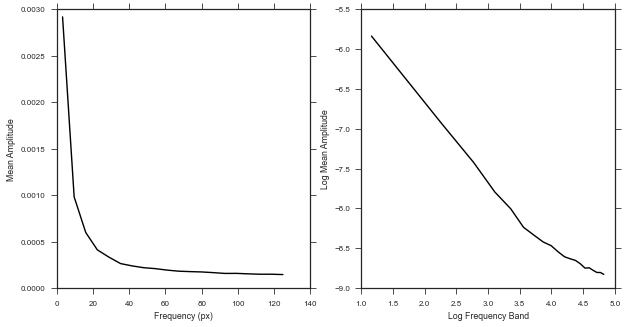

In [8]:
freq, rotavg = get_rotational_average(A, 20)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(freq, rotavg,'k-')
plt.xlabel('Frequency (px)')
plt.ylabel('Mean Amplitude')

plt.subplot(1, 2, 2)
plt.plot(np.log(freq), np.log(rotavg) ,'k-')
plt.xlabel('Log Frequency Band')
plt.ylabel('Log Mean Amplitude')

plt.show()

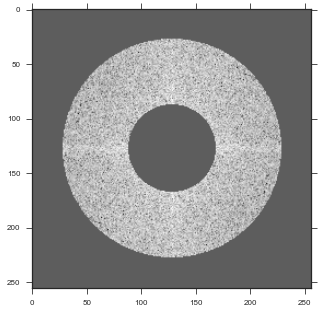

In [9]:
# illustrate a circular band specified by frequency boundaries in pix:
plt.figure(figsize=(5,5))

msk, freq = get_circ_band(A, (40, 100))
plt.imshow(msk*np.log(A),cmap='gray');
# plt.axis('off')

# Which blurs to test?

Pick three values: 0 (i.e. critical level), 1 and our match dprime from the compression comparison.

In [10]:
# dprime function from params
def dprime_fun(x, alpha, beta, scale):
    # return a dprime value given a blur level (x) and
    # the parameters of the model.
    if x <= scale:
        res = 0.
    else:
        res = alpha * np.tanh(beta * (x - scale))
    return res

def loss_dprime(x, fun, target, alpha, beta, scale):
    dprime = fun(x, alpha, beta, scale)
    loss = (target - dprime)**2
    return np.sum(loss)


In [11]:
target_dprimes = [0, 1., 3.]

In [12]:
blur_df = pd.DataFrame()

for dprime in target_dprimes:
    for subj in np.unique(param_df['subj']):
        mask = ((param_df['surround'] == 'blank') &
                (param_df['patch_size'] == 5.95) &
                (param_df['subj'] == subj))

        alpha = param_df.loc[mask, 'alpha'].median()
        beta = param_df.loc[mask, 'beta'].median()
        scale = param_df.loc[mask, 'critical_scale'].median()

        if dprime == 0:
            val = scale
        else:
            ret = minimize_scalar(loss_dprime, args=(dprime_fun, 
                                                     dprime,
                                                     alpha,
                                                     beta, 
                                                     scale))
            print(dprime, subj, ret)
            val = ret['x']
                      
        blur_df = blur_df.append({'subj': subj,
                                  'dprime': dprime,
                                  'blur': val}, ignore_index=True)


1.0 S1   fun: 6.5404586592421642e-20
 nfev: 11
    x: 2.3358534267156315
  nit: 10
1.0 S10   fun: 3.4066686007158079e-17
 nfev: 10
    x: 0.62035940986730009
  nit: 9
1.0 S4   fun: 5.9501297081916779e-18
 nfev: 12
    x: 1.2210702127241098
  nit: 11
3.0 S1   fun: 4.4380762628338601e-19
 nfev: 11
    x: 4.167038882541144
  nit: 10
3.0 S10   fun: 1.1318304627715894e-18
 nfev: 11
    x: 2.1210091874724504
  nit: 10
3.0 S4   fun: 2.9116644040122531e-16
 nfev: 12
    x: 1.9998295575424785
  nit: 11


In [13]:
target_blurs = blur_df.groupby(['dprime']).blur.median()
print(target_blurs)
target_blurs = target_blurs.values

dprime
0         0.916415
1         1.221070
3         2.121009
Name: blur, dtype: float64


## Properties of our threshold Gaussians -- cutoff freqs, etc

The J.F. James book *A student's guide to fourier transforms* specifies the translation between Gaussian width in space and FWHM in frequency.

$$G(x) = e ^{-x^2 / a^2}$$

$$FWHM = 1.665a$$

$$FWHM_{freq} = 0.53/a$$

In [14]:
# translate between width param of J.F. James and gaussian sd:

def gauss_james(x, a):
    return np.exp(-x**2 / a**2)

def normal(x, sd):
    return np.exp(-x**2 / (2 * sd**2))

def a_to_sd(a):
    # james' width param to sd
    return a / np.sqrt(2)

def sd_to_a(sd):
    # sd to width
    return np.sqrt(2) * sd

def fwhm_sd(sd):
    return 2 * np.sqrt(2 * np.log(2)) * sd

def fwhm_a(a):
    return 1.665 * a

def fwhm_fourier(a):
    """ The fwhm in frequency space, given width a.
    From JF James"""
    return 0.53 / a

def fw_10_max_fourier(a):
    """ the width at 10% of maximum in fourier space.
    Not sure how to find???!!?

    The following on Wolfram Alpha might help:
    solve 1 / 10 = exp(-x^2 / a^2) for x
    
    x = +/- a * sqrt(log(10))
    
    then use fourier width of 1 / (pi * a)?
    """
    

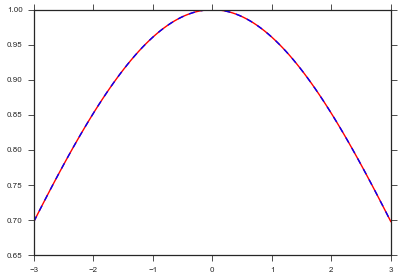

In [15]:
a = 5
x = np.linspace(-3, 3, num=100)
y1 = gauss_james(x, a)
y2 = normal(x, a_to_sd(a))

plt.plot(x, y1, 'r-', x, y2, 'b--');

In [16]:
a = 5
sd = a_to_sd(a)

print(fwhm_sd(sd))
print(fwhm_a(a))

8.32554611158
8.325


In [17]:
print(target_blurs)

[ 0.91641503  1.22107021  2.12100919]


Now we translate them into a FWHM in spatial frequency.

In [18]:
ppd = 43 
print(np.round(target_blurs / ppd, decimals=3))  # blur kernels in degrees

[ 0.021  0.028  0.049]


In [19]:
widths = sd_to_a(target_blurs / ppd)
print(widths)

[ 0.03013969  0.0401594   0.06975721]


In [21]:
print(np.round(fwhm_fourier(widths), decimals=1))

[ 17.6  13.2   7.6]


In [221]:
# because we only care about the radial distance, divide by 2:
# print(np.round(fwhm_fourier(widths) / 2, decimals=2))

# EDIT: this step is wrong, according to Felix.

[ 8.79  6.6   3.8 ]


# Geisler and Perry blurring

Geisler and Perry (1998) outline a multiresolution gaze contingent system that blurs the image away from the fovea. They rely on the detectability of gratings as a function of retinal eccentricity to determine blur cutoffs (see their Fig 4).

**We wish to know the equivalent Gaussian blur kernel used in their system at an eccentricity of 10 degrees**

>In the current system, the foveation regions are determined using the following contrast threshold formula, which is based
upon human contrast sensitivity data measured as a function of spatial frequency and retinal eccentricity:

> $$CT(f, e) = CT_0 \exp \left(\alpha f \frac{e + e_2}{e_2} \right) $$

>where $f$ is spatial frequency (cycles per degree), $e$ is the retinal eccentricity (degrees), $CT_0$ is the minimum contrast threshold, $\alpha$ is the spatial frequency decay constant, and $e_2$ is the half-resolution eccentricity. This formula was selected
because of its simplicity and because it fits published contrast sensitivity data for small, briefly presented patches of grating, which are the most relevant contrast sensitivity data for predicting detectability under naturalistic viewing conditions. The solid curves in Figure 4 show the fit of equation (1) to the contrast sensitivity data (symbols connected by dashed lines) of
Robson & Graham16. Equation (1) also provides an adequate fit to the data of Arnow & Geisler17 and Banks et al.18 (see the caption to Figure 4).

They go on to determine the critical eccentricity for a given frequency to be below threshold:

>Equation (1) can be used to find the critical distance from the foveation point, ec , beyond which a given spatial frequency will be invisible (below threshold) no matter what its contrast. Specifically, the critical eccentricity can be found by setting the left side of equation (1) to 1.0 (the maximum contrast) and solving for $e$:

> $$e_c = \frac{e_2}{\alpha f} \ln \left( \frac{1}{CT_0} \right) - e_2$$

>To apply equation (2), we convert into pixel units by taking into account viewing distance, and we set $f$ to be the Nyquist frequency associated with each level of the pyramid (the highest frequency that can be reliably represented at that level). The resulting values of $e_c$ (and the foveation point, $x_0$, $y_0$) define the foveation regions for each level of the pyramid.

Now I recreate their figure 4 data from the parameters provided.

In [222]:
def ct(f, e, ct_0, alpha, e_2):
    """ Contrast threshold for a given frequency and 
    eccentricity
    """
    y = ct_0 * np.exp(alpha * f * ((e + e_2) / e_2))
    return y

def e_c(f, ct_0, alpha, e_2):
    """Return the critical eccentricity for a given frequency
    to be invisible
    """
    return (e_2 / (alpha * f)) * np.log(1 / ct_0) - e_2

In [223]:
# params taken from their figure caption:
alpha = 0.106
e_2 = 2.3
# ct_0 = 1 / 64  # for banks et al 1991, this is 1 / 76
ct_0 = 1 / 76

# generate some predictions for different frequencies and eccentricities:
dat = pu.misc.expand_grid({'freq': np.array([0.5, 1.5, 3, 6, 12, 18, 24]),
                           'eccent': np.linspace(0, 25, num=25)})

dat.loc[:, 'threshold'] = ct(dat['freq'],
                             dat['eccent'],
                             ct_0,
                             alpha,
                             e_2)

dat.loc[:, 'log_sens'] = np.log10(1 / dat['threshold'])


dat.loc[:, 'crit_eccent'] =  e_c(dat['freq'],
                             ct_0,
                             alpha,
                             e_2)

In [224]:
dat.head()

,freq,eccent,threshold,log_sens,crit_eccent
0,0.5,0.000000,0.013874,1.857796,185.637485
1,0.5,1.041667,0.014211,1.847371,185.637485
2,0.5,2.083333,0.014556,1.836947,185.637485
3,0.5,3.125000,0.014910,1.826522,185.637485
4,0.5,4.166667,0.015272,1.816097,185.637485


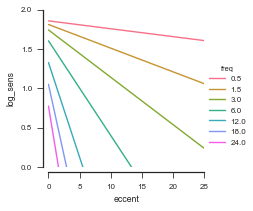

In [225]:
g = sns.FacetGrid(dat, hue='freq')
g.map(plt.plot, 'eccent', 'log_sens');
g.add_legend()
g.set(ylim=(0, 2))
sns.despine(offset=5)

This looks about right (their log y-axis is to base 10).

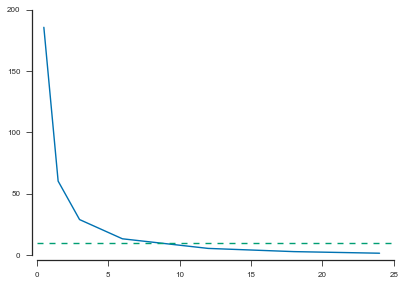

In [226]:
plt.plot(dat['freq'], dat['crit_eccent'])
plt.plot((0, 25), (10, 10), ls='--')
sns.despine(offset=5);

In [227]:
# critical frequency for 10 degrees:
def ec_loss(f, ecc):
    if f <= 0:
        f = np.exp(-20)
    
    crit = e_c(f, ct_0, alpha, e_2)
    error = (ecc - crit)**2
    return error

ret = minimize_scalar(ec_loss, args=(10))
ret

    x: 7.639735168062832
  fun: 1.3235763524790072e-15
 nfev: 11
  nit: 10

So at 10 degrees, this equation predicts that 7.63 cpd and all higher frequencies should be invisible...

In [228]:
# inner edge of stim:
bounds_cpd = []

ret = minimize_scalar(ec_loss, args=(13))
bounds_cpd.append(ret['x'])

ret = minimize_scalar(ec_loss, args=(7))
bounds_cpd.append(ret['x'])

print(bounds_cpd)

[6.1417478626680886, 10.104165769143142]


We could compute the proportional signal attenuation in that frequency range for all images...

# Helper funcs

In [229]:
def match_ims(a, b):
    """ Match the mean of image b to
    image a; return image b.

    """
    a = img_as_float(a)
    b = img_as_float(b)
    renormed = (b - b.mean()) + a.mean()
    renormed[renormed < 0.] = 0.
    renormed[renormed > 1.] = 1.
    return renormed


def renorm_im(im, rms):
    """ Function to renormalise the contrast and mean
    of the image. Assumes image is a float and mean should
    be 0.5 """
    im = pu.image.contrast_image(im, sd=rms/2., returns="contrast")
    im += 0.5

    im[im < 0] = 0
    im[im > 1] = 1
    return im


def check_vals(im, rms):
    # absolute tolerance set so that values round to
    # desired mean / sd...
    assert_allclose(im.mean(), 0.5, atol=0.005)
    assert_allclose(im.std() / im.mean(),
                    rms, atol=0.005)


def check_vals_loop(im, rms):
    im = renorm_im(im, rms)

    try:
        check_vals(im, rms)
    except AssertionError:
        close = False
        while close is False:
            im = renorm_im(im, rms)
            try:
                check_vals(im, rms)
                close = True
            except AssertionError:
                close = False
    return im


def blur_loop(im_code, blur, f_ranges,
              n_filts=20):
    """ For a given image, source the original large file,
    blur, compute rotational averages.
    
    If blur == 0, the original image rotational average is 
    returned.
    
    f_ranges is a tuple giving the lower and upper bounds of a
    region of interest (in pixels).
    """
    im = io.imread(os.path.join(original_ims, '{}.jpeg'.format(im_code)),
                                as_grey=True)
    im = pu.image.cutout_patch(im, 768)
    im = check_vals_loop(im, 0.3)  # normalise rms
    
    if blur == 0.:
        # original image.
        # crop:
        im = pu.image.cutout_patch(im, 256)
        
        # take fft:
        a, p, s = do_fourier_transform(im)
    elif blur == -99.: 
        # Geisler and perry image:
        im = io.imread(os.path.join(top_dir, 'code', 'analysis', 
                                    'geisler_perry_ims', '{}.png'.format(im_code)),
                                    as_grey=True)
        im = img_as_float(im)
        # take fft:
        a, p, s = do_fourier_transform(im)        
    else:
        blr = gaussian_filter(im, sigma=blur,
                              mode='constant',
                              cval=orig.mean())
        # crop:
        blr = pu.image.cutout_patch(blr, 256)

        # renorm mean:
        blr = match_ims(im, blr)

        # take fft:
        a, p, s = do_fourier_transform(blr)
        
    freq, vals = get_rotational_average(a, n_filts)
    
    # the mean amplitude in a specified frequency range:
    range_mask, range_middle = get_circ_band(a, (f_ranges[0], f_ranges[1]))
    bound_amp = np.mean(a[range_mask].flatten())/a.size
    
    return freq, vals, bound_amp        


# Demo for one image

In [230]:
im_data = pd.read_csv(os.path.join(im_dir, 'patch_info.csv'))
im_data = im_data.loc[im_data['size'] == 256]
im_data.to_csv(os.path.join(top_dir, 'code', 'analysis', 
                            'geisler_perry_ims', 'im_data.csv'))
im_data.info()
test_im = im_data['filename'][0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 199
Data columns (total 12 columns):
filename          100 non-null object
inner_rms         100 non-null float64
middle_rms        100 non-null float64
outer_rms         100 non-null float64
sal_inner_mean    100 non-null float64
sal_inner_sd      100 non-null float64
sal_mid_mean      100 non-null float64
sal_mid_sd        100 non-null float64
sal_outer_mean    100 non-null float64
sal_outer_sd      100 non-null float64
size              100 non-null float64
source_rms        100 non-null float64
dtypes: float64(11), object(1)
memory usage: 10.2+ KB


image is of type <class 'numpy.ndarray'>
image has data type float64
image has dimensions (256, 256)
image has range from 0.26 to max 0.71
the mean of the image is 0.46
the SD of the image is 0.15
the rms contrast (SD / mean) is 0.34


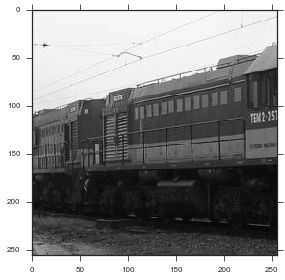

In [231]:
# load the original image:
orig = io.imread(os.path.join(im_dir, 
                              '{}_mid_nat.png'.format(test_im)),
                as_grey=True)
show_im(orig)

image is of type <class 'numpy.ndarray'>
image has data type float64
image has dimensions (256, 256)
image has range from 0.33 to max 0.74
the mean of the image is 0.5
the SD of the image is 0.15
the rms contrast (SD / mean) is 0.29


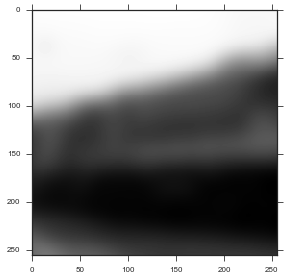

In [232]:
im = io.imread(os.path.join(original_ims, '{}.jpeg'.format(test_im)),
                            as_grey=True)
im = pu.image.cutout_patch(im, 768)
im = check_vals_loop(im, 0.3)  # normalise rms

blr = gaussian_filter(im, sigma=10,
                      mode='constant',
                      cval=orig.mean())
# crop, renorm:
blr = pu.image.cutout_patch(blr, 256)

# renorm mean:
blr = match_ims(im, blr)

# take fft:
a, p, s = do_fourier_transform(im)

freq, vals = get_rotational_average(a, 20)

show_im(blr)

image is of type <class 'numpy.ndarray'>
image has data type float64
image has dimensions (256, 256)
image has range from 0.28 to max 0.69
the mean of the image is 0.46
the SD of the image is 0.15
the rms contrast (SD / mean) is 0.32


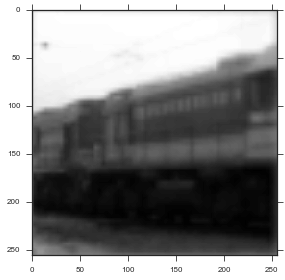

In [233]:
# check a geisler and perry im:
im = io.imread(os.path.join(top_dir, 'code', 'analysis', 
                            'geisler_perry_ims', '{}.png'.format(test_im)),
                            as_grey=True)
im = img_as_float(im)
show_im(im)

# Loop over images and blurs

In [234]:
# prepare variables:
def px_to_cpd(x):
    x = np.array(x)
    ppd = 43
    nyquist_cpi = 256 / 2
    nyquist_cpd = nyquist_cpi / (256 / ppd)
    return (x / nyquist_cpi) * nyquist_cpd


def cpd_to_px(x):
    x = np.array(x)
    ppd = 43
    nyquist_cpi = 256 / 2
    nyquist_cpd = nyquist_cpi / (256 / ppd)
    return (x / nyquist_cpd) * nyquist_cpi

In [235]:
# convert geisler and perry range back to pixels
bounds_px = cpd_to_px(bounds_cpd)

In [236]:
target_blurs = blur_df.groupby(['dprime']).blur.median()
target_blurs = np.round(target_blurs.values, decimals=3)
target_blurs = np.append(target_blurs, 0.)
target_blurs.sort()
target_blurs

array([ 0.   ,  0.916,  1.221,  2.121])

In [237]:
labels = ['Original',
          'Critical blur',
          '$d^\prime=1$',
          '$d^\prime=3$']
labels

['Original', 'Critical blur', '$d^\\prime=1$', '$d^\\prime=3$']

In [238]:
# add geisler and perry ims in:
target_blurs = np.append(target_blurs, -99.)
labels.append('Geisler & Perry')

In [239]:
print(target_blurs)
print(labels)

[  0.      0.916   1.221   2.121 -99.   ]
['Original', 'Critical blur', '$d^\\prime=1$', '$d^\\prime=3$', 'Geisler & Perry']


In [240]:
dat = pd.DataFrame()

for im_code in im_data['filename']:
    print(im_code)
    for blur, label in zip(target_blurs, labels):
        x, y, bound_amp = blur_loop(im_code, 
                                    blur, 
                                    bounds_px, 
                                    n_filts=20)
        for i in range(len(x)):
            dat = dat.append({'im_code': im_code,
                              'blur': blur,
                              'label': label,
                              'freq': x[i],
                              'amp': y[i],
                              'bound_amp': bound_amp}, ignore_index=True)
        
    

i1464437389
i2290794919
i1865070582
i2252058417
i102423191
i2289739189
i2270102601
i2237929211
i1297641633
i1139671063
i1362671223
i2203431935
i2174164459
i170746079
i2174162303
i1808007663
i19023164
i350435387
i2235879193
i2117655611
i1473135008
i2171576731
i205838601
i2131629177
i1503092014
i160271625
i2224739969
i1394080896
i1918259724
i192592020
i1739584262
i1361149388
i2301631442
i2300011983
i167462665
i1000978947
i2281390450
i2253396498
i2291666088
i2286138209
i30may05_static_street_cambridge_p1010735
istatic_street_outdoor_palma_mallorca_spain_IMG_0805
istatic_hotel_room_indoor_IMG_0999
istatic_barcelona_street_city_outdoor_2005_img_0391
i105918635
i1507520018
i1014163009
i163125223
istatic_boston_street_april_p1010184
i30may05_static_street_cambridge_p1010717
i2246755161
i123476629
i2237729434
i176365896
i1346278050
i103385035
i2168068710
i159875849
i1791248749
istatic_outdoor_road_mallorca_spain_IMG_0641
i2138748225
i2113390015
i1142164052
istatic_barcelona_street_city_outdoor

In [241]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 6 columns):
amp          10000 non-null float64
blur         10000 non-null float64
bound_amp    10000 non-null float64
freq         10000 non-null float64
im_code      10000 non-null object
label        10000 non-null object
dtypes: float64(4), object(2)
memory usage: 546.9+ KB


In [242]:
dat.head()

,amp,blur,bound_amp,freq,im_code,label
0,0.005607,0,0.000119,3.2,i1464437389,Original
1,0.000911,0,0.000119,9.6,i1464437389,Original
2,0.000440,0,0.000119,16.0,i1464437389,Original
3,0.000278,0,0.000119,22.4,i1464437389,Original
4,0.000216,0,0.000119,28.8,i1464437389,Original


## Prepare variables for plotting

Frequency is currently expressed in pixels (radius from centre). Convert to cpd, plot on log scale.. 

In [243]:
# prepare variables:
dat.loc[:, 'freq_cpd'] = px_to_cpd(dat.loc[:, 'freq'])
dat.loc[:, 'log_freq_cpd'] = np.log10(dat.loc[:, 'freq_cpd'])
dat.loc[:, 'log_amp'] = np.log10(dat.loc[:, 'amp'])
dat.loc[:, 'log_bound_amp'] = np.log10(dat.loc[:, 'bound_amp'])

In [244]:
dat['freq_cpd'].describe()

count    10000.000000
mean        10.750000
std          6.199062
min          0.537500
25%          5.643750
50%         10.750000
75%         15.856250
max         20.962500
Name: freq_cpd, dtype: float64

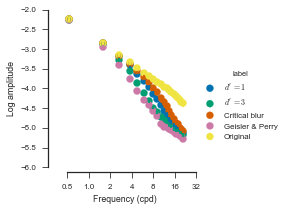

In [245]:
g = sns.lmplot('log_freq_cpd', 'log_amp', dat,
               hue='label',
               x_estimator=np.mean,
               size=3,
               fit_reg=False)
# g.set_xticklabels(np.array([-0.5, 0, 0.5, 1., 1.5])**10)
g.set(xticks=np.log10(np.array([0.5, 1., 2, 4, 8, 16, 32])))
g.set_xticklabels([0.5, 1., 2, 4, 8, 16, 32])
g.set_axis_labels("Frequency (cpd)", "Log amplitude")
g.despine(offset=5, trim=True);


### Replot as average line, with subplot for attenuations

In [246]:
# compute average amplitudes over images:
avs = dat.groupby(['log_freq_cpd', 'label']).log_amp.mean() 
avs = avs.reset_index()

avs.head()

,log_freq_cpd,label,log_amp
0,-0.269622,$d^\prime=1$,-2.249990
1,-0.269622,$d^\prime=3$,-2.254053
2,-0.269622,Critical blur,-2.249102
3,-0.269622,Geisler & Perry,-2.267558
4,-0.269622,Original,-2.247878


In [247]:
# compute attenuations (OH GOD THIS CODE IS HACKY; THERE MUST BE A BETTER WAY)

attenuations = pd.DataFrame()

orig_amps = dat.loc[dat['label'] == 'Original', :].groupby(['im_code', 'label']).bound_amp.mean()
orig_amps = orig_amps.reset_index()

for l in np.unique(dat['label']):
    lab = dat.loc[dat['label'] == l, :].groupby(['im_code', 'label']).bound_amp.mean()
    lab = lab.reset_index()
    atten = lab['bound_amp'] / orig_amps['bound_amp']
#     atten = atten.mean()  # average over images.
    for i, code in enumerate(np.unique(lab['im_code'])):
        attenuations = attenuations.append({'label': l,
                                            'im_code': code,
                                            'attenuation': atten[i]}, ignore_index=True)

# lab = dat.groupby(['im_code', 'label', 'log_freq_cpd']).bound_amp.mean()
# atten = lab / orig_amps
# attenuations = attenuations.append(atten.reset_index(), ignore_index=True)
    
# average over images:


In [248]:
attenuations.head()

,attenuation,im_code,label
0,0.388935,i05june05_static_street_boston_p1010806,$d^\prime=1$
1,0.401740,i1000978947,$d^\prime=1$
2,0.470028,i1014163009,$d^\prime=1$
3,0.518140,i102423191,$d^\prime=1$
4,0.390659,i103385035,$d^\prime=1$


In [249]:
# discard original for plotting:
attenuations = attenuations.loc[attenuations['label'] != 'Original', :]

In [250]:
bounds_cpd

[6.1417478626680886, 10.104165769143142]

In [251]:
np.array([bounds_cpd[1], 32])

array([ 10.10416577,  32.        ])

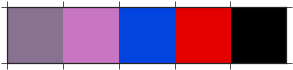

In [275]:
cols = ['greyish purple', 'orchid', 'blue', 'red', 'black']
# sns.set_palette(sns.color_palette("cubehelix", 5))
sns.palplot(sns.xkcd_palette(cols))
sns.set_palette(sns.xkcd_palette(cols))

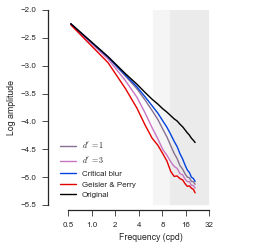

In [276]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

# fill shading for regions:
bounds_x = np.log10(bounds_cpd)
bounds_y = [-5.5, -2.0]

ax.fill_between(bounds_x, bounds_y[0], bounds_y[1],
               color='0.96')

bounds_x = np.log10(np.array([bounds_cpd[1], 32]))

# ax.fill_between(bounds_x, bounds_y[0], bounds_y[1],
#                color='#fee0d2')
ax.fill_between(bounds_x, bounds_y[0], bounds_y[1],
               color='0.92')

for l in np.unique(avs['label']):
    plt.plot(avs.loc[avs['label'] == l, 'log_freq_cpd'],
             avs.loc[avs['label'] == l, 'log_amp'],
             label=l)
    
ax.set(xticks=np.log10(np.array([0.5, 1., 2, 4, 8, 16, 32])))
ax.set_xticklabels([0.5, 1., 2, 4, 8, 16, 32])
plt.xlabel("Frequency (cpd)")
plt.ylabel("Log amplitude")
plt.legend(loc='lower left')
sns.despine(offset=5, trim=True);
plt.savefig(os.path.join(fig_dir,'spectral_content.pdf'), bbox_inches='tight')

/Users/tomwallis/miniconda3/envs/default/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


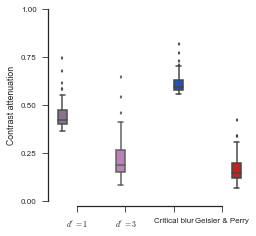

In [277]:
g = sns.factorplot('label', 'attenuation', data=attenuations,
                   hue='label', kind='box', size=3.5)
g.set_axis_labels('', 'Contrast attenuation')
g.set(yticks=np.linspace(0, 1, 5))
sns.despine(offset=5, trim=True);

In [278]:
g.savefig(os.path.join(fig_dir,'spectral_attenuation.pdf'))

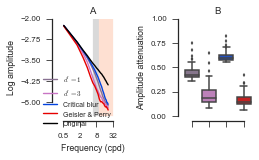

In [279]:
# can we do on one plot using matplotlib subplots?
fig, ax = plt.subplots(ncols=2, figsize=(3.5, 3.5/2))


### First plot ###
# fill shading for regions:
bounds_x = np.log10(bounds_cpd)
bounds_y = [-5.5, -2.0]

ax[0].fill_between(bounds_x, bounds_y[0], bounds_y[1],
               color='0.85')

bounds_x = np.log10(np.array([bounds_cpd[1], 32]))

ax[0].fill_between(bounds_x, bounds_y[0], bounds_y[1],
               color='#fee0d2')

for l in np.unique(avs['label']):
    ax[0].plot(avs.loc[avs['label'] == l, 'log_freq_cpd'],
             avs.loc[avs['label'] == l, 'log_amp'],
             label=l)
    
ax[0].set(xticks=np.log10(np.array([0.5, 2, 8, 32])))
ax[0].set_xticklabels([0.5, 2, 8, 32])
ax[0].set_xlabel("Frequency (cpd)")

ax[0].set(yticks=np.linspace(-5, -2, num=5))
ax[0].set_ylabel("Log amplitude")
ax[0].legend(fontsize='x-small',
             bbox_to_anchor=(0.85, 0.5))
ax[0].set_title('A')


### Second plot ###
# sns.violinplot(attenuations['attenuation'], groupby=attenuations['label'],
#                inner='points', widths=1, vert=False, saturation=1,
#             ax=ax[1])

# ax[1].set_xticks(np.linspace(0, 1, 5))
# ax[1].set_xlabel('Contrast attenuation')
# ax[1].set_ylabel('')

# violins have weird color issue.
sns.boxplot(attenuations['attenuation'], groupby=attenuations['label'],
            ax=ax[1])

ax[1].set_yticks(np.linspace(0, 1, 5))
ax[1].set_ylabel('Amplitude attenuation')
ax[1].set_xlabel('')
# ax[1].set_xticklabels(np.unique(attenuations['label']), rotation='vertical')
ax[1].set_xticklabels(['', '', ''], rotation=45)
# ax[1].tick_params(axis='x', labelsize=6)
ax[1].set_title('B')


fig.subplots_adjust(wspace=0.8)

sns.despine(offset=5, trim=True);
plt.savefig(os.path.join(fig_dir, 'spectral_content_multiplot.pdf'), bbox_inches='tight');